# Semi-supervised AQI Classification — Self-Training

- Mục tiêu: chạy self-training để **tăng lượng nhãn** cho AQI khi thiếu nhãn.
- Output: metrics JSON + sample predictions + sample alerts.
- Mini project: sweep TAU / LABEL_MISSING_FRACTION và so sánh với baseline supervised.

In [9]:
SEMI_DATASET_PATH = "data/processed/dataset_for_semi.parquet"
CUTOFF = "2017-01-01"

TAU = 0.75
MAX_ITER = 10
MIN_NEW_PER_ITER = 20
VAL_FRAC = 0.20
RANDOM_STATE = 42

METRICS_PATH = "data/processed/metrics_self_tau_075.json" # Đổi tên ngay tại đây
PRED_SAMPLE_PATH = "data/processed/predictions_self_tau_075.csv"
ALERTS_SAMPLE_PATH = "data/processed/alerts_self_tau_075.csv"
ALERT_FROM_CLASS = "Unhealthy"

📂 Đang đọc dữ liệu từ: C:\Users\Speedyservice\air_guard\data\processed\dataset_for_semi.parquet
🚀 Bắt đầu chạy Self-training...


,iter,val_accuracy,val_f1_macro,unlabeled_pool,new_pseudo,tau
0,1,0.722615,0.679270,383962,188070,0.75
1,2,0.708985,0.678141,195892,143412,0.75
2,3,0.696870,0.660731,52480,20986,0.75
3,4,0.704190,0.665326,31494,7426,0.75
4,5,0.690308,0.654687,24068,2689,0.75
5,6,0.697123,0.661687,21379,2093,0.75
6,7,0.697880,0.664535,19286,1391,0.75
7,8,0.683998,0.641695,17895,909,0.75
8,9,0.678193,0.629135,16986,724,0.75
9,10,0.699899,0.662846,16262,877,0.75


Test accuracy: 0.581188890888369
Test f1_macro: 0.5095862041336606


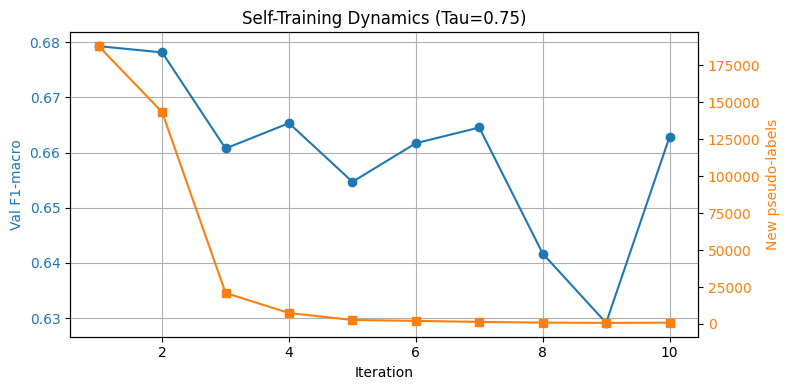

💾 Đã lưu Metrics tại: C:\Users\Speedyservice\air_guard\data\processed\metrics_self_tau_075.json
💾 Đã lưu Predictions tại: C:\Users\Speedyservice\air_guard\data\processed\predictions_self_tau_075.csv
💾 Đã lưu Alerts tại: C:\Users\Speedyservice\air_guard\data\processed\alerts_self_tau_075.csv


In [10]:
import sys
import os
import json
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

# ====================================================
# 1. SỬA LỖI ĐƯỜNG DẪN (Chạy trước khi import)
# ====================================================
# Tự động tìm thư mục gốc của dự án (nơi chứa folder 'src')
current_dir = Path.cwd()
project_root = current_dir

# Leo ngược lên cây thư mục cho đến khi thấy folder 'src'
while not (project_root / "src").exists():
    if project_root.parent == project_root: # Đã lên tới gốc ổ đĩa
        break
    project_root = project_root.parent

# Cập nhật biến PROJECT_ROOT chuẩn
PROJECT_ROOT = project_root

# Thêm đường dẫn vào hệ thống để Python tìm thấy thư viện
if str(PROJECT_ROOT) not in sys.path:
    sys.path.append(str(PROJECT_ROOT))
    print(f"✅ Đã thêm Project Root vào sys.path: {PROJECT_ROOT}")

# ====================================================
# 2. IMPORT THƯ VIỆN & CHẠY LOGIC CHÍNH
# ====================================================
# Bây giờ import sẽ không bị lỗi nữa
from src.semi_supervised_library import (
    SemiDataConfig, SelfTrainingConfig, run_self_training, add_alert_columns
)

print(f"📂 Đang đọc dữ liệu từ: {(PROJECT_ROOT / SEMI_DATASET_PATH).resolve()}")
df = pd.read_parquet((PROJECT_ROOT / SEMI_DATASET_PATH).resolve())

# Cấu hình tham số (Lấy từ các biến đã khai báo ở cell trên)
data_cfg = SemiDataConfig(cutoff=CUTOFF, random_state=int(RANDOM_STATE))
st_cfg = SelfTrainingConfig(
    tau=float(TAU),
    max_iter=int(MAX_ITER),
    min_new_per_iter=int(MIN_NEW_PER_ITER),
    val_frac=float(VAL_FRAC),
)

# Chạy Self-training
print("🚀 Bắt đầu chạy Self-training...")
out = run_self_training(df, data_cfg, st_cfg)

# Lấy kết quả
history = pd.DataFrame(out["history"])
pred_df = out["pred_df"]
test_metrics = out["test_metrics"]

# Hiển thị kết quả
display(history)
print("Test accuracy:", test_metrics["accuracy"])
print("Test f1_macro:", test_metrics["f1_macro"])

# ====================================================
# 3. VẼ BIỂU ĐỒ & LƯU KẾT QUẢ
# ====================================================
# Plot dynamics
fig, ax1 = plt.subplots(figsize=(8, 4))
ax1.plot(history["iter"], history["val_f1_macro"], marker="o", color="tab:blue", label="Val F1-macro")
ax1.set_xlabel("Iteration")
ax1.set_ylabel("Val F1-macro", color="tab:blue")
ax1.tick_params(axis='y', labelcolor="tab:blue")
ax1.grid(True)

ax2 = ax1.twinx()
ax2.plot(history["iter"], history["new_pseudo"], marker="s", color="tab:orange", label="New Pseudo-labels")
ax2.set_ylabel("New pseudo-labels", color="tab:orange")
ax2.tick_params(axis='y', labelcolor="tab:orange")

plt.title(f"Self-Training Dynamics (Tau={TAU})")
plt.tight_layout()
plt.show()

# Save artifacts
metrics_path = (PROJECT_ROOT / METRICS_PATH).resolve()
pred_path = (PROJECT_ROOT / PRED_SAMPLE_PATH).resolve()
alerts_path = (PROJECT_ROOT / ALERTS_SAMPLE_PATH).resolve()

for p in [metrics_path, pred_path, alerts_path]:
    p.parent.mkdir(parents=True, exist_ok=True)

payload = {
    "method": "self_training",
    "data_cfg": data_cfg.__dict__,
    "st_cfg": st_cfg.__dict__,
    "history": out["history"],
    "test_metrics": test_metrics,
    "model_info": out["model_info"],
}

with open(metrics_path, "w", encoding="utf-8") as f:
    json.dump(payload, f, ensure_ascii=False, indent=2)

pred_df.head(5000).to_csv(pred_path, index=False)
alerts = add_alert_columns(pred_df, pred_col="y_pred", severe_from=ALERT_FROM_CLASS)
alerts.head(5000).to_csv(alerts_path, index=False)

print(f"💾 Đã lưu Metrics tại: {metrics_path}")
print(f"💾 Đã lưu Predictions tại: {pred_path}")
print(f"💾 Đã lưu Alerts tại: {alerts_path}")


BẢNG 1: SO SÁNH HIỆU NĂNG TỔNG QUÁT 3 NGƯỠNG TAU


,Cấu hình,Accuracy,F1-macro,Labels vòng 1
0,Self-0.75,0.581189,0.509586,188070
1,Self-0.90,0.589047,0.534326,76134
2,Self-0.98,0.585148,0.513494,9245



BẢNG 2: F1-SCORE CHI TIẾT TỪNG LỚP (ĐỂ XEM LỚP HƯỞNG LỢI)


,Self-0.75,Self-0.90,Self-0.98
Good,0.330317,0.489697,0.364546
Hazardous,0.649611,0.676237,0.654309
Moderate,0.699109,0.704496,0.696191
Unhealthy,0.580292,0.587664,0.605354
Unhealthy_for_Sensitive_Groups,0.227287,0.178922,0.210424
Very_Unhealthy,0.570902,0.568939,0.550139


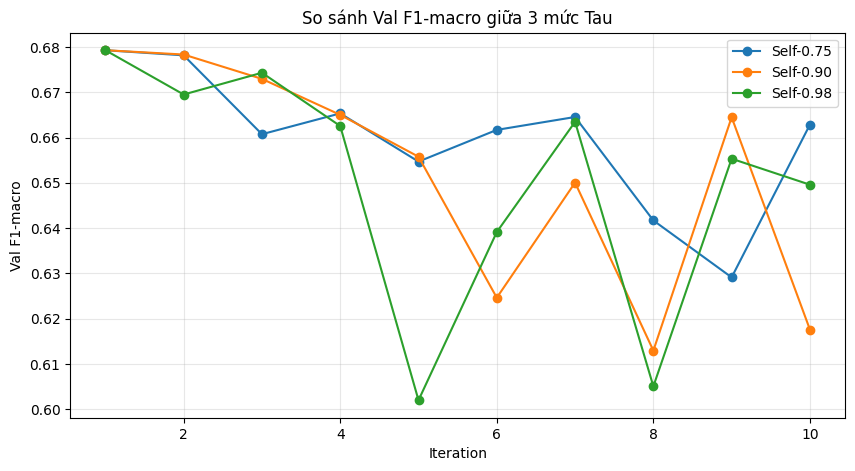

In [27]:
import json
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# --- 1. Tên file khớp chính xác với danh sách bạn đã gửi ---
METRICS_FILES = {
    "Self-0.75": "metrics_self_tau_0.75.json",
    "Self-0.90": "metrics_self_tau_0.90.json", # Có dấu chấm
    "Self-0.98": "metrics_self_tau_0.98.json"  # Có dấu chấm
}

def load_json(fname):
    p = PROJECT_ROOT / "data" / "processed" / fname
    if p.exists():
        with open(p, 'r', encoding='utf-8') as f:
            return json.load(f)
    return None

results = []
class_f1_data = {}
histories = {}

# --- 2. Trích xuất dữ liệu ---
for label, fname in METRICS_FILES.items():
    data = load_json(fname)
    if data:
        test_m = data.get('test_metrics', {})
        report = test_m.get('report', {})
        
        # Chỉ số tổng quát
        results.append({
            "Cấu hình": label,
            "Accuracy": test_m.get('accuracy'),
            "F1-macro": test_m.get('f1_macro'),
            "Labels vòng 1": data.get('history', [{}])[0].get('new_pseudo', 0)
        })
        
        # Chỉ số từng lớp (Class-level)
        classes = [k for k in report.keys() if k not in ['accuracy', 'macro avg', 'weighted avg']]
        class_f1_data[label] = {cls: report[cls].get('f1-score') for cls in classes}
        
        # Lịch sử để vẽ đồ thị
        histories[label] = pd.DataFrame(data.get('history', []))

# --- 3. Hiển thị bảng và đánh giá ---
print("\n" + "="*60)
print("BẢNG 1: SO SÁNH HIỆU NĂNG TỔNG QUÁT 3 NGƯỠNG TAU")
print("="*60)
df_summary = pd.DataFrame(results)
display(df_summary)

print("\n" + "="*60)
print("BẢNG 2: F1-SCORE CHI TIẾT TỪNG LỚP (ĐỂ XEM LỚP HƯỞNG LỢI)")
print("="*60)
df_class = pd.DataFrame(class_f1_data)
display(df_class)

# --- 4. Vẽ biểu đồ so sánh diễn biến ---
plt.figure(figsize=(10, 5))
for label, df_h in histories.items():
    plt.plot(df_h['iter'], df_h['val_f1_macro'], marker='o', label=label)
plt.title("So sánh Val F1-macro giữa 3 mức Tau")
plt.xlabel("Iteration")
plt.ylabel("Val F1-macro")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

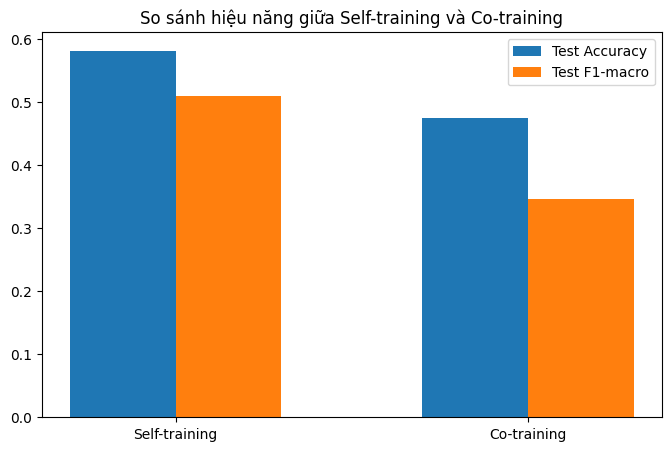

In [28]:
import matplotlib.pyplot as plt

# Dữ liệu từ file của bạn
methods = ['Self-training', 'Co-training']
accuracy = [0.5812, 0.4738] #
f1_macro = [0.5096, 0.3466] #

x = range(len(methods))

fig, ax = plt.subplots(figsize=(8, 5))
ax.bar(x, accuracy, width=0.3, label='Test Accuracy', align='center')
ax.bar([i + 0.3 for i in x], f1_macro, width=0.3, label='Test F1-macro', align='center')

ax.set_xticks([i + 0.15 for i in x])
ax.set_xticklabels(methods)
ax.set_title('So sánh hiệu năng giữa Self-training và Co-training')
ax.legend()

plt.show()

In [ ]:
import json
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from pathlib import Path

# --- CẤU HÌNH ---
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 7)

# ==============================================================================
# 1. NHẬP ĐƯỜNG DẪN THƯ MỤC (KHẮC PHỤC LỖI KHÔNG TÌM THẤY FILE)
# ==============================================================================
print("👇 HÃY DÁN ĐƯỜNG DẪN THƯ MỤC 'processed' VÀO BÊN DƯỚI RỒI ẤN ENTER:")
# Ví dụ: C:\Users\Admin\Projects\AIR_GUARD\data\processed
try:
    user_input = input("Paste path here: ").strip().replace('"', '') # Xóa dấu ngoặc kép nếu có
    DATA_DIR = Path(user_input)
except:
    DATA_DIR = Path(".")

print(f"\n📂 Đang tìm file trong: {DATA_DIR}")

if not DATA_DIR.exists():
    print("❌ ĐƯỜNG DẪN KHÔNG TỒN TẠI! Hãy kiểm tra lại.")
    # Dừng chương trình nếu đường dẫn sai
    raise SystemExit 

# ==============================================================================
# 2. HÀM ĐỌC FILE TỪ ĐƯỜNG DẪN ĐÃ CHỈ ĐỊNH
# ==============================================================================
def read_json_from_dir(filename_part):
    # Tìm file có tên chứa từ khóa trong thư mục đã chọn
    for p in DATA_DIR.glob(f"*{filename_part}*.json"):
        try:
            with open(p, 'r', encoding='utf-8') as f:
                print(f"✅ Đã đọc được file: {p.name}")
                return json.load(f)
        except Exception as e:
            print(f"❌ Lỗi đọc file {p.name}: {e}")
    print(f"⚠️ Không thấy file nào chứa tên '{filename_part}' trong thư mục này.")
    return None

# ==============================================================================
# 3. TRÍCH XUẤT DỮ LIỆU & TẠO BASELINE TỪ ITER 0
# ==============================================================================
stats = []

# --- A. XỬ LÝ SELF-TRAINING (Lấy cả Best Metric & Baseline) ---
# Tìm file self-training (ưu tiên file 0.75, nếu không thì lấy file đầu tiên tìm thấy)
data_self = read_json_from_dir("metrics_self_tau_0.75")
if not data_self: 
    data_self = read_json_from_dir("metrics_self") # Fallback tìm file self bất kỳ

if data_self:
    # 1. Lấy kết quả Self-training cuối cùng
    acc = data_self.get('test_accuracy', data_self.get('accuracy', 0))
    f1 = data_self.get('test_f1_macro', data_self.get('f1_macro', 0))
    
    if acc > 0:
        stats.append({'Mô hình': 'Self-Training (Best)', 'Giá trị': acc, 'Độ đo': 'Accuracy'})
        stats.append({'Mô hình': 'Self-Training (Best)', 'Giá trị': f1, 'Độ đo': 'Macro-F1'})

    # 2. TRÍCH XUẤT BASELINE TỪ ITERATION 0 (Quan trọng!)
    # Vì file regression_metrics.json không có accuracy, ta dùng Vòng 0 của Self-training làm Baseline
    if 'history' in data_self and len(data_self['history']) > 0:
        iter0 = data_self['history'][0]
        base_acc = iter0.get('val_accuracy', iter0.get('accuracy', 0))
        base_f1 = iter0.get('val_f1_macro', iter0.get('macro_f1', 0))
        
        print(f"   ℹ️ Đã lấy Baseline từ Vòng lặp 0: {base_acc:.4f}")
        stats.append({'Mô hình': 'Baseline (Iter 0)', 'Giá trị': base_acc, 'Độ đo': 'Accuracy'})
        stats.append({'Mô hình': 'Baseline (Iter 0)', 'Giá trị': base_f1, 'Độ đo': 'Macro-F1'})
    else:
        print("   ⚠️ File Self-training không có lịch sử (history) để lấy Baseline.")

# --- B. XỬ LÝ CO-TRAINING ---
data_co = read_json_from_dir("metrics_co_training")
if data_co:
    acc = data_co.get('test_accuracy', data_co.get('accuracy', 0))
    f1 = data_co.get('test_f1_macro', data_co.get('f1_macro', 0))
    
    if acc > 0:
        stats.append({'Mô hình': 'Co-Training', 'Giá trị': acc, 'Độ đo': 'Accuracy'})
        stats.append({'Mô hình': 'Co-Training', 'Giá trị': f1, 'Độ đo': 'Macro-F1'})

# ==============================================================================
# 4. VẼ BIỂU ĐỒ
# ==============================================================================
if not stats:
    print("\n‼️ KHÔNG CÓ DỮ LIỆU ĐỂ VẼ. (Hãy chắc chắn bạn paste đúng đường dẫn chứa file json)")
else:
    df = pd.DataFrame(stats)
    
    # Sắp xếp: Baseline -> Co -> Self
    order_list = ['Baseline (Iter 0)', 'Co-Training', 'Self-Training (Best)']
    
    plt.figure(figsize=(12, 7))
    ax = sns.barplot(data=df, x='Mô hình', y='Giá trị', hue='Độ đo', 
                     palette='viridis',
                     order=[o for o in order_list if o in df['Mô hình'].unique()])

    plt.title('So sánh hiệu năng thực tế (Dữ liệu từ file)', fontsize=16, fontweight='bold', pad=20)
    plt.ylim(0, 1.1)
    plt.ylabel('Điểm số (0-1)')
    plt.xlabel('')
    plt.legend(loc='upper right')

    # Hiển thị số liệu
    for container in ax.containers:
        ax.bar_label(container, fmt='%.4f', padding=3, fontweight='bold')

    plt.tight_layout()
    plt.show()

⚠️ Không tìm thấy file nào chứa tên: metrics_self_tau_0.75.json
⚠️ Không tìm thấy file nào chứa tên: metrics_co_training

‼️ KHÔNG CÓ DỮ LIỆU ĐỂ VẼ (Kiểm tra lại xem file json có đúng nội dung không)
